## 인물사진을 만들어 보자

#### <하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법>
1. 배경이 있는 사진을 촬영합니다.
2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(인물)와 배경을 분리합니다.
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
4. 피사체를 배경의 원래 위치에 합성합니다.

In [1]:
import os
import sys
import random
import math
import skimage.io
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(1280, 1280, 3)


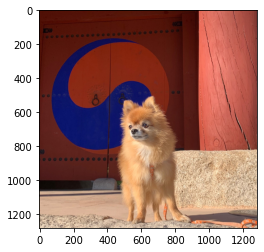

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/coco.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 2. 세그멘테이션으로 인물 분리하기

- 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됨
- 오늘은 그중에서 DeepLab이라는 세그멘테이션 모델을 이용함
- DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있음

> 먼저 PixelLib에서 제공해 주는 모델을 다운로드

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0d843dc0d0>)

> 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

> PASCAL VOC 데이터의 라벨 종류

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

> 모델 출력값 살펴보기

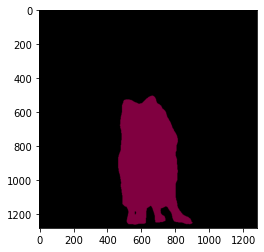

In [6]:
plt.imshow(output)
plt.show()

In [7]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [8]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


class_ids를 통해 어떤 물체가 담겨있는지 알 수 있다.

> 물체마다 output에 어떤 색상으로 나타나 있는지 알아보기

In [9]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

> 'dog'를 나타내는 12번째 색상은 무엇일까?

In [10]:
colormap[12]

array([ 64,   0, 128])

In [11]:
seg_color = (128,0,64)

output 이미지가 BGR 순서로 채널 배치가 되어 있다. 반면 colormap은 RGB 순서이므로, 우리가 추출해야 하는 색상 값은 순서를 (128,0,64)로 바꿔 준다.

> seg_color로만 이루어진 마스크 만들기

(1280, 1280)


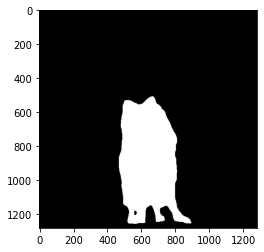

In [12]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

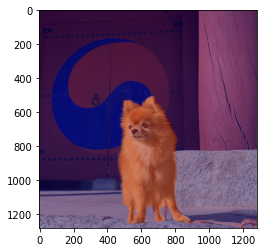

In [13]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 3. 배경 흐리게 하기

> blur() 함수를 이용하여 배경을 흐리게 만든다.

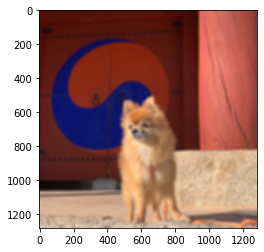

In [14]:
# (20,20)은 blurring kernel size를 뜻합니다
img_orig_blur = cv2.blur(img_orig, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

> 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

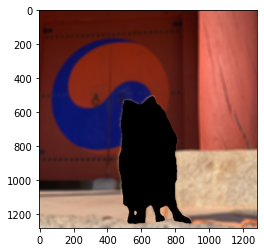

In [15]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# bitwise_not 함수를 이용하면 이미지가 반전됨
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 4. 흐린 배경과 원본 영상 합성

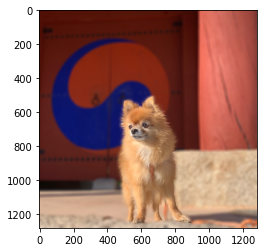

In [16]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 원본과 비교하기

(BEFORE)
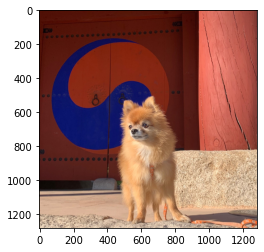

(AFTER)
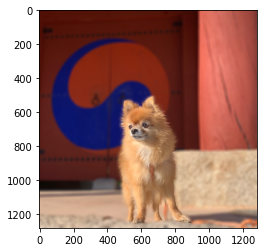

--------------------------------------------------------------------

## 프로젝트 : 인물모드 문제점 찾기

- 3장의 다른 인물사진으로 위의 과정을 거쳐 셸로우 포커스 만들기
- 문제점이 있는 결과물은 개선하기

> 1번 사진

(1126, 1170, 3)


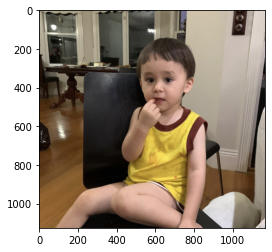

In [17]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/ben.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0d07d840a0>)

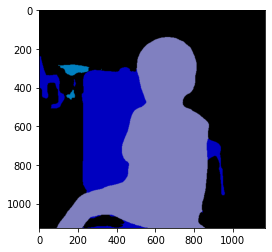

In [19]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

plt.imshow(output)
plt.show()

In [20]:
segvalues

{'class_ids': array([ 0,  9, 11, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [21]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
diningtable
person


In [22]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [23]:
colormap[15]

array([192, 128, 128])

In [24]:
seg_color = (128,128,192)

(1126, 1170)


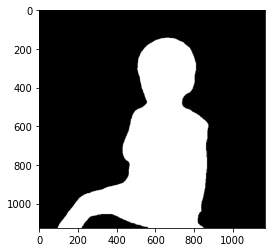

In [25]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

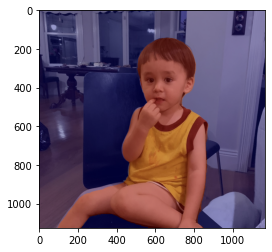

In [26]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

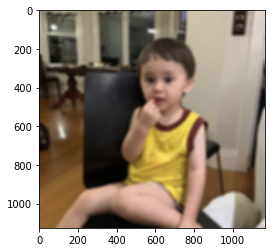

In [27]:
# (20,20)은 blurring kernel size를 뜻합니다
img_orig_blur = cv2.blur(img_orig, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

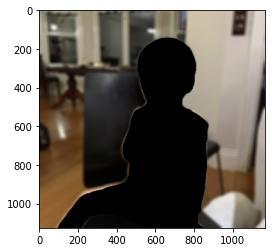

In [28]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# bitwise_not 함수를 이용하면 이미지가 반전됨
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

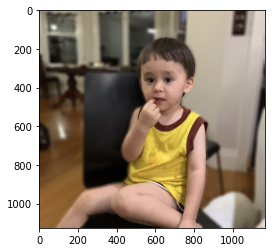

In [29]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

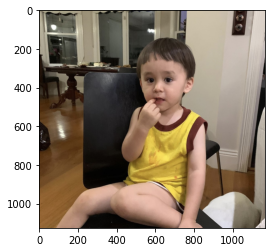 (BEFORE와 비교)

------------------------------------------------------------------------------------------------------------

> 2번 사진

(1155, 1170, 3)


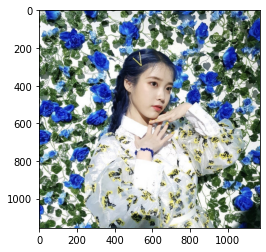

In [30]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/iu.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [31]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0d05555fd0>)

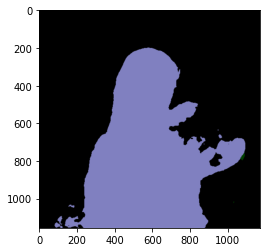

In [32]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

plt.imshow(output)
plt.show()

In [33]:
segvalues

{'class_ids': array([ 0, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [34]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant


In [35]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [36]:
colormap[15]

array([192, 128, 128])

In [37]:
seg_color = (128,128,192)

(1155, 1170)


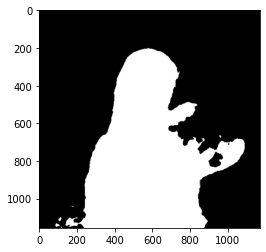

In [38]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

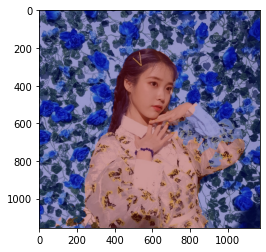

In [39]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

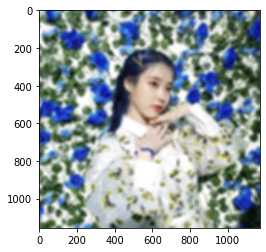

In [40]:
# (20,20)은 blurring kernel size를 뜻합니다
img_orig_blur = cv2.blur(img_orig, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

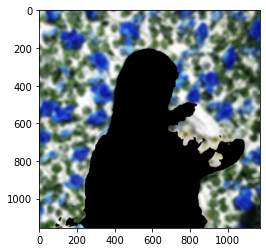

In [41]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# bitwise_not 함수를 이용하면 이미지가 반전됨
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

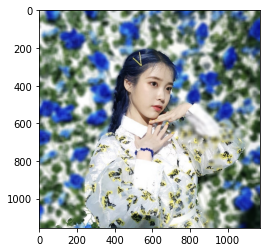

In [42]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

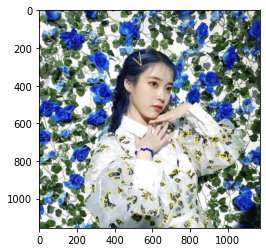 (BEFORE와 비교)

------------------------------------------------------------------------------------------------------------

> 3번 사진

(1411, 1170, 3)


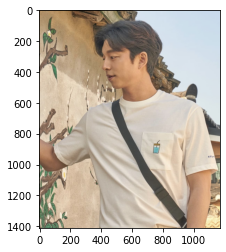

In [43]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/0u.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [44]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0d84225df0>)

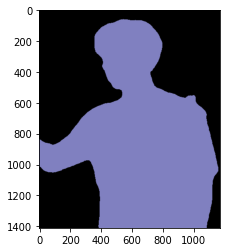

In [45]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

plt.imshow(output)
plt.show()

In [46]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [47]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [48]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [49]:
colormap[15]

array([192, 128, 128])

In [50]:
seg_color = (128,128,192)

(1411, 1170)


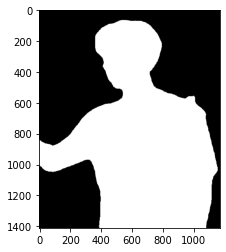

In [51]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

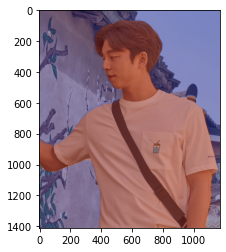

In [52]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

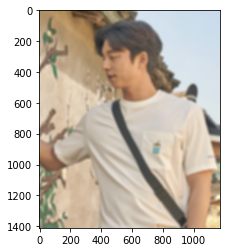

In [53]:
# (20,20)은 blurring kernel size를 뜻합니다
img_orig_blur = cv2.blur(img_orig, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

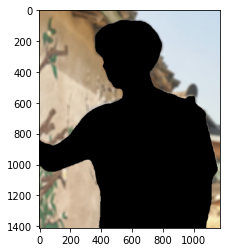

In [54]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# bitwise_not 함수를 이용하면 이미지가 반전됨
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

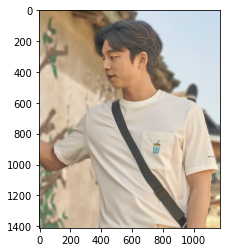

In [55]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

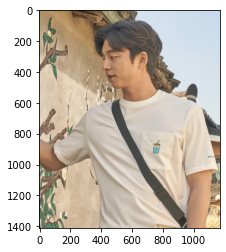 (BEFORE와 비교)

----------------------------------------------------------------------------------------------------

> 문제가 발생한 인물사진

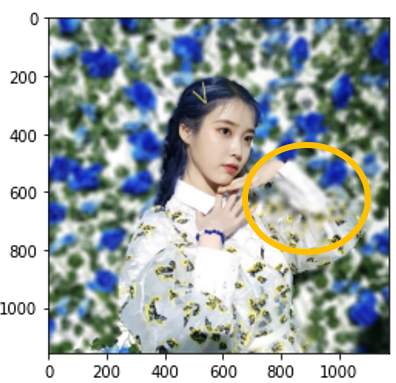

background 부분만 흐려져야 하는데 인물영역의 일부인 손목 부분에도 blur처리가 되어버렸다.

> 해결방안

- ToF 방식을 사용
 - ToF란 비행시간의 약자로써 피사체로 보낸 빛이 반사되어 돌아오는 시간을 측정한 뒤, 사물을 인식하는 3D센싱 기술이다.
 - 피사체 초점을 빠르게 잡아주며 증강현실(AR), 가상현실(VR) 및 얼굴인식 카메라 분야 등에 활용됨

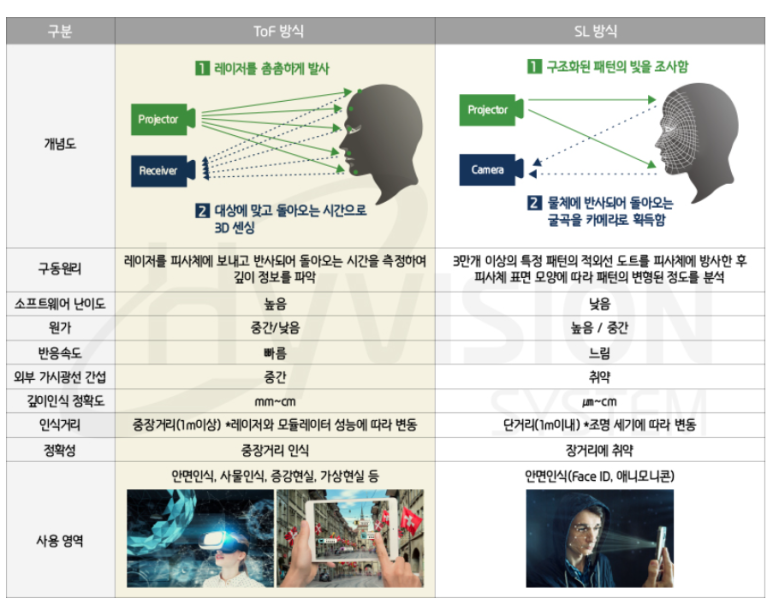

이 방식을 사용하면 보다 정확한 Image Segmentation 이 가능 할 것 같다.